In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def split_train_test(data,test_ratio):
    shuffled_ind = np.random.permutation(len(data))
    test_set_len = int(len(data)*test_ratio)
    test_indices = shuffled_ind[:test_set_len]
    train_indices = shuffled_ind[test_set_len:]
    return data.iloc[train_indices], data.iloc[test_indices]

data = pd.read_csv("housing.csv")
data = data.drop(['total_bedrooms'],axis=1)

# data.head()

In [69]:
df = data
df1 = df[df.isnull().any(axis=1)]
df1

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity


In [83]:
# data = data[~data.isin(['NaN', 'NaT']).any(axis=1)]

# data.replace(["NaN", 'NaT'], np.nan, inplace = True)

cols = list(data)
cols.remove("ocean_proximity")
data.dropna(subset = cols)
data.fillna(data.mean())
print(data.sample(5))

print(data.info())

print(data['ocean_proximity'].value_counts())


print(data.describe())

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
7238     -118.13     34.01                40.0       2412.0           629.0   
7996     -118.15     33.86                32.0       2630.0           559.0   
9351     -122.55     37.97                52.0       2232.0           291.0   
17655    -121.89     37.25                26.0       1741.0           323.0   
5524     -118.37     33.98                39.0        303.0            69.0   

       population  households  median_income  median_house_value  \
7238       2119.0       600.0         2.0750            151100.0   
7996       1069.0       491.0         2.4659            209000.0   
9351        731.0       253.0         7.1155            500001.0   
17655      1007.0       339.0         4.7069            234800.0   
5524        131.0        73.0         4.3438            331800.0   

      ocean_proximity  
7238        <1H OCEAN  
7996        <1H OCEAN  
9351         NEAR BAY  
17655       <1H OCEA

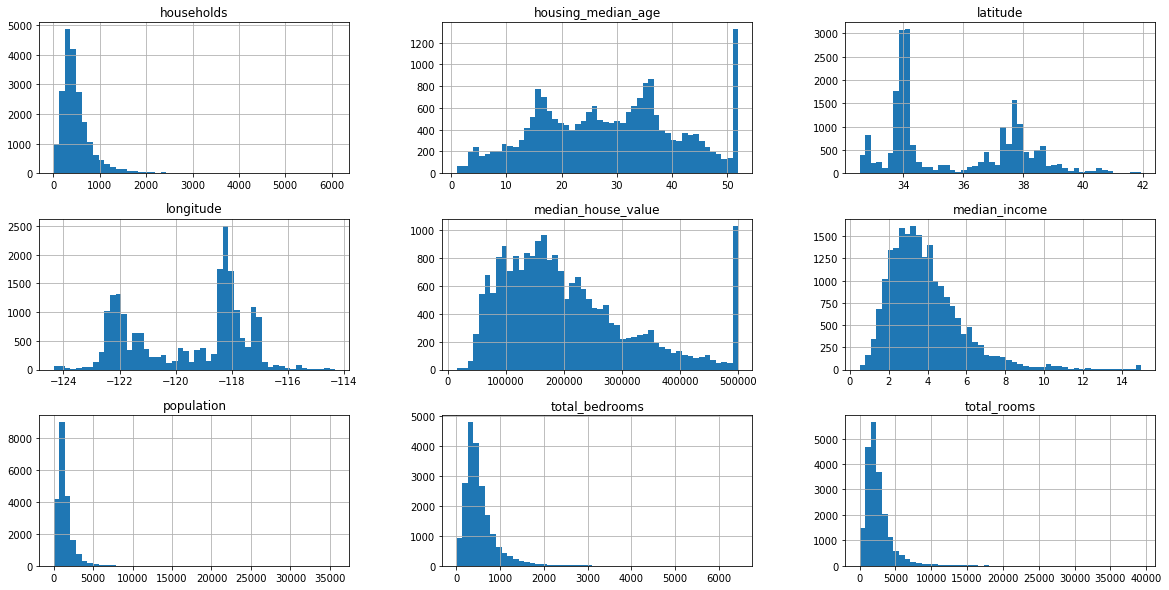

In [27]:
data.hist(bins=50,figsize=(20,10))
plt.show()

In [74]:
train_set, test_set = split_train_test(data,.3)

print(len(train_set),len(test_set))

14448 6192


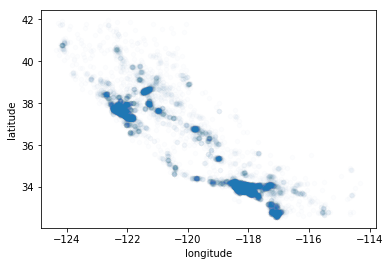

In [29]:
train_set.plot(kind="scatter",x="longitude",y="latitude",alpha=.01)

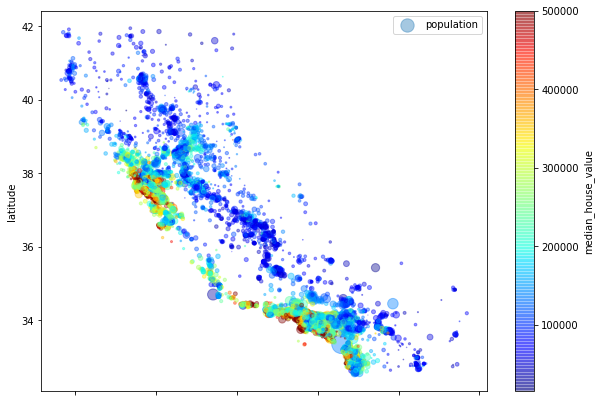

In [30]:
# didn't understand fully
train_set.plot(kind="scatter",x="longitude",y="latitude",alpha=.4,s=train_set["population"]/100,label="population",figsize=(10,7),c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()

In [31]:
#correlation analysis
corr_matrix = train_set.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686930
total_rooms           0.139555
housing_median_age    0.108392
households            0.068043
total_bedrooms        0.051434
population           -0.025208
longitude            -0.048119
latitude             -0.143571
Name: median_house_value, dtype: float64

In [75]:
print(len(train_set))
train_set.dropna()
print(len(train_set))

14448
14448


In [76]:
#encoding a column

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

housing_cat = train_set["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
# housing_cat_encoded

# train_set["ocean_proximity"]

In [77]:
# preprocessing data
# transforming data

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion


# num_pipeline = Pipeline([('encoder',LabelEncoder()),('std_scaler', StandardScaler)])

# housing_transform = num_pipeline.fit_transform(train_set)

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self,x):
        return self
    
    def transform(self,x):
        x_shape = x[self.attribute_names].shape
        return x[self.attribute_names].values.reshape(x_shape)
    
#     def fit_transform(self, X, y=None):
#         self.fit(X)
#         return self.transform(X)


class CustomBinarizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None,**fit_params):
        return self
    def transform(self, X):
        return LabelEncoder().fit(X).transform(X).reshape(X.shape)  
    

class CustomNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None,**fit_params):
        return self
    def transform(self, X):

        return StandardScaler().fit(X).transform(X)
    
housing_train = train_set.drop("median_house_value",axis=1)
housing_labels = train_set["median_house_value"].copy()





all_columns = list(housing_train)
all_columns.remove("ocean_proximity")
all_columns.remove("total_rooms")
print(all_columns)


cat_attribute = ["ocean_proximity"]
cat_pipeline = Pipeline([('selector',DataFrameSelector(cat_attribute)),('encoder',CustomBinarizer())])

std_total_rooms = ["total_rooms"]
total_rooms_pipeline = Pipeline([('selector',DataFrameSelector(std_total_rooms)),('std_normalizer',CustomNormalizer())])


gen_pipeline = Pipeline([('selector',DataFrameSelector(all_columns))])




full_pipeline = FeatureUnion(transformer_list=[("genpipeline",gen_pipeline),("cat_pipeline",cat_pipeline),("std_pipeline_total_room",total_rooms_pipeline)])

data_prepared = full_pipeline.fit_transform(housing_train)
print(data_prepared.shape)
data_prepared


['longitude', 'latitude', 'housing_median_age', 'population', 'households', 'median_income']
(14448, 8)


C:\Users\anik\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anik\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[-1.22020000e+02,  3.69600000e+01,  5.20000000e+01, ...,
         2.01720000e+00,  4.00000000e+00, -8.61104861e-01],
       [-1.21510000e+02,  3.85800000e+01,  4.20000000e+01, ...,
         1.25420000e+00,  1.00000000e+00, -3.81219302e-01],
       [-1.21970000e+02,  3.75300000e+01,  3.50000000e+01, ...,
         4.75000000e+00,  0.00000000e+00, -1.72673047e-01],
       ...,
       [-1.22300000e+02,  3.80000000e+01,  3.40000000e+01, ...,
         4.43940000e+00,  3.00000000e+00, -4.31637078e-01],
       [-1.19740000e+02,  3.67700000e+01,  3.00000000e+01, ...,
         2.57370000e+00,  1.00000000e+00, -1.03921534e-01],
       [-1.18280000e+02,  3.39800000e+01,  4.30000000e+01, ...,
         1.57500000e+00,  0.00000000e+00, -6.47975171e-01]])

In [81]:
# training and mean square error on training set


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(data_prepared,housing_labels)

forest_reg = RandomForestRegressor()
scores = cross_val_score(lin_reg,data_prepared,housing_labels,scoring="neg_mean_squared_error",cv=5)
scores_rfr = cross_val_score(forest_reg,data_prepared,housing_labels,scoring="neg_mean_squared_error",cv=5)

print(scores.mean())
print(scores_rfr.mean())

-4795150258.571827
-2726950142.296199


In [99]:
# hyperparameter tuning

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

forest_reg = RandomForestRegressor()
print(forest_reg.get_params())

param_grid = [{'max_features':[2,4,6,8],'n_estimators':[3,10,30]}]

grid_search = GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(data_prepared,housing_labels)

print(grid_search.best_params_)
print(grid_search.best_estimator_)




{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
{'max_features': 4, 'n_estimators': 30}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [98]:
# which feature is more important


feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances)

attributes = list(housing_train)+list(encoder.classes_)

print(sorted(zip(feature_importances, attributes),reverse=True))

# print(encoder.classes_)

# but in the book the occean_proximity was most important ... that proves how important feature engineering is ... 

[0.14030889 0.13668623 0.05224327 0.04205135 0.03450238 0.47377421
 0.08459103 0.03584263]
[(0.47377421312839957, 'households'), (0.1403088927546102, 'longitude'), (0.13668622916760326, 'latitude'), (0.08459103445314937, 'median_income'), (0.05224326825592329, 'housing_median_age'), (0.04205134859375443, 'total_rooms'), (0.03584263309606423, 'ocean_proximity'), (0.03450238055049556, 'population')]


In [105]:
# running of test set
# really bad prediction 

from sklearn.metrics import mean_squared_error


final_model = grid_search.best_estimator_

# print(list(test_set))
x_test = test_set.drop("median_house_value",axis = 1)
y_test = test_set["median_house_value"].copy()

x_test_prepared = full_pipeline.transform(x_test)
final_prediction = final_model.predict(x_test_prepared)

final_mse = mean_squared_error(y_test,final_prediction)
print(final_mse)

2479172496.3822603


C:\Users\anik\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anik\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
